# Writing Your Own GPU Kernel, `torch.compile`, and Data Types

The [beginner notebook](demo_4090.ipynb) showed how to download pre-compiled kernels. The [advanced notebook](demo_4090_advanced.ipynb) showed kernel fusion and model patching. This notebook goes one step further:

1. **Write your own GPU kernel from scratch** using Triton — a Python-like language for GPU programming
2. **`torch.compile`** — PyTorch's built-in compiler that auto-fuses operations (no manual kernel writing needed)
3. **Four-way race** — compare PyTorch eager, your Triton kernel, Hub kernel, and `torch.compile` head-to-head
4. **Data types** — how fp32, fp16, and bf16 affect performance and when to use each
5. **Memory footprint** — how fusion reduces peak GPU memory, not just speed
6. **Compile a full model** — apply `torch.compile` to a complete transformer block and compare with manual kernel patching

In [1]:
import time
import torch
import torch.nn as nn
import triton
import triton.language as tl
import matplotlib.pyplot as plt
import numpy as np
from kernels import get_kernel

act_kernel = get_kernel("kernels-community/activation")
norm_kernel = get_kernel("kernels-community/triton-layer-norm")

print(f"GPU:    {torch.cuda.get_device_name(0)}")
print(f"Torch:  {torch.__version__}")
print(f"Triton: {triton.__version__}")


def benchmark(func, iterations=300, warmup=30):
    """Benchmark a GPU function. Returns average time in milliseconds."""
    for _ in range(warmup):
        func()
    torch.cuda.synchronize()
    start = time.perf_counter()
    for _ in range(iterations):
        func()
    torch.cuda.synchronize()
    return (time.perf_counter() - start) / iterations * 1000

/home/rob/PythonEnvironments/Kernels/.kernels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 84126.44it/s]


GPU:    NVIDIA GeForce RTX 4090
Torch:  2.10.0+cu126
Triton: 3.6.0


---
## Part 1: Writing a GPU Kernel From Scratch with Triton

### What is Triton?

[Triton](https://triton-lang.org/) is a language and compiler for writing GPU kernels in Python. Instead of writing raw CUDA C++ (hundreds of lines, easy to get wrong), you write Python-like code and Triton compiles it to optimized GPU assembly.

**The tradeoff:**
- **CUDA C++**: Maximum control, maximum complexity. You manage every thread, every memory access.
- **Triton**: ~90% of the performance, ~10% of the complexity. Triton handles thread management and memory coalescing for you.
- **torch.compile**: Zero manual work, but less control. PyTorch's compiler generates Triton kernels automatically.

### Our first kernel: Fused SiLU + Multiply

We'll write the same fused `SiLU(gate) * up` operation from the advanced notebook, but this time as our own Triton kernel.

Here's the complete kernel — 15 lines of actual code:

In [2]:
@triton.jit
def silu_mul_kernel(
    # Pointers to the input and output tensors in GPU memory
    gate_ptr, up_ptr, out_ptr,
    # Total number of elements to process
    n_elements,
    # How many elements each "program" (thread block) processes
    BLOCK_SIZE: tl.constexpr,
):
    # Which block am I? (like a thread ID, but for blocks of elements)
    pid = tl.program_id(0)

    # Calculate which elements this block handles
    # Example: if BLOCK_SIZE=1024, block 0 handles elements 0-1023,
    #          block 1 handles 1024-2047, etc.
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

    # Don't read past the end of the array
    mask = offsets < n_elements

    # Load gate and up values from GPU memory
    # Cast gate to fp32 for the sigmoid computation (more accurate)
    gate = tl.load(gate_ptr + offsets, mask=mask).to(tl.float32)
    up = tl.load(up_ptr + offsets, mask=mask)

    # SiLU(x) = x * sigmoid(x)
    # This is the actual math — computed in fast on-chip registers,
    # no intermediate tensor written to slow global memory!
    silu = gate * tl.sigmoid(gate)

    # Multiply by 'up' and store result
    result = silu.to(up.dtype) * up
    tl.store(out_ptr + offsets, result, mask=mask)


print("Kernel defined! Key concepts:")
print("  @triton.jit    — compiles this Python function into GPU machine code")
print("  tl.program_id  — which block of elements am I processing?")
print("  tl.load/store  — read from / write to GPU memory")
print("  tl.constexpr   — compile-time constant (Triton optimizes for this value)")
print("  mask           — boundary check (don't read past end of array)")

Kernel defined! Key concepts:
  @triton.jit    — compiles this Python function into GPU machine code
  tl.program_id  — which block of elements am I processing?
  tl.load/store  — read from / write to GPU memory
  tl.constexpr   — compile-time constant (Triton optimizes for this value)
  mask           — boundary check (don't read past end of array)


### The Python wrapper

A Triton kernel operates on raw memory pointers. We need a thin Python wrapper that:
1. Allocates the output tensor
2. Calculates the grid size (how many blocks to launch)
3. Calls the kernel

In [3]:
def triton_silu_mul(gate: torch.Tensor, up: torch.Tensor) -> torch.Tensor:
    """Fused SiLU(gate) * up using our custom Triton kernel."""
    assert gate.shape == up.shape
    assert gate.is_cuda

    out = torch.empty_like(gate)
    n = gate.numel()

    # Grid: how many blocks to launch?
    # Each block processes BLOCK_SIZE elements, so we need ceil(n / BLOCK_SIZE) blocks
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)

    # Launch the kernel on the GPU
    # Triton compiles it to GPU assembly the first time, then caches it
    silu_mul_kernel[grid](gate, up, out, n, BLOCK_SIZE=1024)

    return out


# Test it!
gate = torch.randn((4096, 11008), dtype=torch.float16, device="cuda")
up = torch.randn((4096, 11008), dtype=torch.float16, device="cuda")

our_result = triton_silu_mul(gate, up)
pytorch_result = torch.nn.functional.silu(gate) * up
torch.cuda.synchronize()

diff = (our_result - pytorch_result).abs().max().item()
print(f"Shape: {gate.shape}")
print(f"Max difference: {diff:.8f}")
print(f"Correct: {'PASS' if diff < 0.01 else 'FAIL'}")
print()
print(f"We just wrote a GPU kernel in Python and it produced the same")
print(f"result as PyTorch, processing {gate.numel():,} numbers in parallel.")

Shape: torch.Size([4096, 11008])
Max difference: 0.00048828
Correct: PASS

We just wrote a GPU kernel in Python and it produced the same
result as PyTorch, processing 45,088,768 numbers in parallel.


---
## Part 2: Four-Way Race

Now the moment of truth. We have four ways to compute `SiLU(gate) * up`:

| Approach | How it works | Effort |
|----------|-------------|--------|
| **PyTorch eager** | Two separate ops, two memory round-trips | Zero (default) |
| **Our Triton kernel** | Fused, one memory round-trip | ~15 lines of Triton |
| **Hub kernel** | Pre-compiled fused kernel from HuggingFace | One line (`get_kernel`) |
| **torch.compile** | PyTorch auto-generates a fused Triton kernel | One decorator (`@torch.compile`) |

Let's race them.

In [4]:
# Prepare torch.compile version
@torch.compile
def compiled_silu_mul(gate, up):
    return torch.nn.functional.silu(gate) * up

# Warm up torch.compile (first call triggers compilation)
for _ in range(5):
    compiled_silu_mul(gate, up)
torch.cuda.synchronize()

# Prepare Hub kernel version
gate_up_cat = torch.cat([gate, up], dim=-1).contiguous()
out_hub = torch.empty_like(gate)

# Race!
results = {}

results['PyTorch eager'] = benchmark(
    lambda: torch.nn.functional.silu(gate) * up
)
results['Our Triton kernel'] = benchmark(
    lambda: triton_silu_mul(gate, up)
)
results['Hub kernel'] = benchmark(
    lambda: act_kernel.silu_and_mul(out_hub, gate_up_cat)
)
results['torch.compile'] = benchmark(
    lambda: compiled_silu_mul(gate, up)
)

eager_ms = results['PyTorch eager']
print(f"{'Approach':<22} {'Time (ms)':>10} {'Speedup':>8}")
print("=" * 44)
for name, ms in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name:<22} {ms:>8.4f}   {eager_ms/ms:>6.2f}x")

Approach                Time (ms)  Speedup
Our Triton kernel        0.2903     1.68x
torch.compile            0.2905     1.68x
Hub kernel               0.2938     1.66x
PyTorch eager            0.4872     1.00x


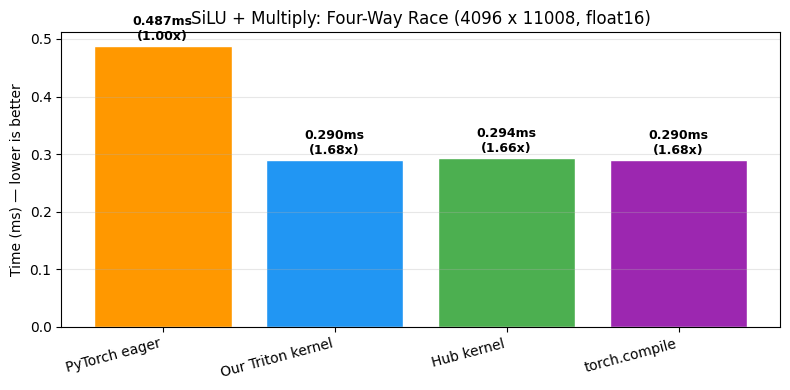

All three optimized approaches hit roughly the same speed.
That's because they all do the same thing: fuse two operations into one
memory round-trip. The memory bandwidth ceiling is the same for all of them.


In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

names = list(results.keys())
times = [results[n] for n in names]
speedups = [eager_ms / t for t in times]
colors = ['#FF9800', '#2196F3', '#4CAF50', '#9C27B0']

bars = ax.bar(range(len(names)), times, color=colors, edgecolor='white')
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=15, ha='right')
ax.set_ylabel('Time (ms) — lower is better')
ax.set_title('SiLU + Multiply: Four-Way Race (4096 x 11008, float16)')
ax.grid(True, alpha=0.3, axis='y')

for bar, ms, speedup in zip(bars, times, speedups):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{ms:.3f}ms\n({speedup:.2f}x)', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("All three optimized approaches hit roughly the same speed.")
print("That's because they all do the same thing: fuse two operations into one")
print("memory round-trip. The memory bandwidth ceiling is the same for all of them.")

### Why are the three optimized approaches nearly identical?

They all solve the same problem the same way:
1. Read `gate` and `up` from memory (one trip)
2. Compute `SiLU(gate) * up` in fast on-chip registers
3. Write the result back (one trip)

The memory bandwidth of the 4090 (1,008 GB/s) is the hard ceiling. Once you eliminate the intermediate write (which all three approaches do), you've hit the wall. No amount of cleverness can make the GPU's memory bus faster.

This is a key insight: **for memory-bound operations, the optimal kernel performance converges**. The difference between approaches is in ergonomics, not speed:

- **torch.compile**: Easiest — just add a decorator. But opaque, and you can't customize the fusion strategy.
- **Hub kernels**: One-liner to use, battle-tested, but limited to what's published.
- **Custom Triton**: Full control — you can fuse arbitrary operations, add custom logic, target specific shapes. More work, but sometimes it's the only option.

---
## Part 3: Writing a More Complex Kernel — Fused RMSNorm

The SiLU+mul kernel was simple because every element is independent — element `i` of the output depends only on element `i` of the inputs. RMSNorm is harder because it requires a **reduction**: you need the mean of *all* elements in a row to normalize *each* element.

$$\text{RMSNorm}(x) = \frac{x}{\sqrt{\text{mean}(x^2) + \epsilon}} \cdot \gamma$$

This means a single thread block must process an entire row, computing the sum of squares, then normalizing every element.

In [6]:
@triton.jit
def rmsnorm_kernel(
    x_ptr, weight_ptr, out_ptr,
    n_rows, n_cols,
    eps,
    BLOCK_SIZE: tl.constexpr,
):
    # Each program handles one row
    row_idx = tl.program_id(0)
    row_start = row_idx * n_cols

    # --- Pass 1: Compute sum of squares for this row ---
    sum_sq = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for col_offset in range(0, n_cols, BLOCK_SIZE):
        cols = col_offset + tl.arange(0, BLOCK_SIZE)
        mask = cols < n_cols
        x = tl.load(x_ptr + row_start + cols, mask=mask, other=0.0).to(tl.float32)
        sum_sq += x * x

    # Mean of squares across all columns
    mean_sq = tl.sum(sum_sq) / n_cols
    # Reciprocal square root: 1 / sqrt(mean(x^2) + eps)
    rrms = 1.0 / tl.sqrt(mean_sq + eps)

    # --- Pass 2: Normalize and scale ---
    for col_offset in range(0, n_cols, BLOCK_SIZE):
        cols = col_offset + tl.arange(0, BLOCK_SIZE)
        mask = cols < n_cols
        x = tl.load(x_ptr + row_start + cols, mask=mask, other=0.0).to(tl.float32)
        w = tl.load(weight_ptr + cols, mask=mask, other=0.0).to(tl.float32)
        normed = x * rrms * w
        tl.store(out_ptr + row_start + cols, normed.to(tl.float16), mask=mask)


def triton_rmsnorm(x: torch.Tensor, weight: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """RMSNorm using our custom Triton kernel."""
    assert x.ndim == 2
    n_rows, n_cols = x.shape
    out = torch.empty_like(x)
    # One program per row, with BLOCK_SIZE elements per iteration
    grid = (n_rows,)
    rmsnorm_kernel[grid](x, weight, out, n_rows, n_cols, eps, BLOCK_SIZE=1024)
    return out


# Test it
n_tokens, hidden_size = 2048, 4096
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
weight = torch.ones(hidden_size, dtype=torch.float16, device="cuda")

our_out = triton_rmsnorm(x, weight)
ref_out = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")(x)
torch.cuda.synchronize()

diff = (our_out - ref_out).abs().max().item()
print(f"RMSNorm correctness: max diff = {diff:.8f} ({'PASS' if diff < 0.01 else 'FAIL'})")
print()
print("This kernel is more complex because it needs two passes over each row:")
print("  Pass 1: Read all elements, compute sum of squares")
print("  Pass 2: Read elements again, normalize using the computed RMS, write output")
print("Each pass iterates in chunks of BLOCK_SIZE for rows wider than 1024.")

RMSNorm correctness: max diff = 0.00195312 (PASS)

This kernel is more complex because it needs two passes over each row:
  Pass 1: Read all elements, compute sum of squares
  Pass 2: Read elements again, normalize using the computed RMS, write output
Each pass iterates in chunks of BLOCK_SIZE for rows wider than 1024.


In [7]:
# Benchmark our RMSNorm against PyTorch and Hub kernel
pytorch_rmsnorm = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")

token_counts = [512, 1024, 2048, 4096, 8192]

print(f"RMSNorm benchmark: hidden_size={hidden_size}")
print(f"{'Tokens':>8} {'Our Triton':>12} {'PyTorch':>12} {'Hub':>12} {'Ours/PT':>8}")
print("-" * 56)

rmsnorm_results = []

for n in token_counts:
    x = torch.randn((n, hidden_size), dtype=torch.float16, device="cuda")
    w = torch.ones(hidden_size, dtype=torch.float16, device="cuda")

    ours = benchmark(lambda: triton_rmsnorm(x, w))
    pt = benchmark(lambda: pytorch_rmsnorm(x))
    hub = benchmark(lambda: norm_kernel.rms_norm_fn(x, w, None, eps=1e-6))

    rmsnorm_results.append((n, ours, pt, hub))
    print(f"{n:>8} {ours:>10.4f}   {pt:>10.4f}   {hub:>10.4f}   {pt/ours:>6.2f}x")

print()
print("Our simple Triton kernel is a first draft — the Hub kernel's Triton code")
print("is more sophisticated (better vectorization, shared memory usage).")
print("But even a basic Triton kernel gets you in the right ballpark.")

RMSNorm benchmark: hidden_size=4096
  Tokens   Our Triton      PyTorch          Hub  Ours/PT
--------------------------------------------------------
     512     0.0117       0.0120       0.1269     1.03x
    1024     0.0129       0.0172       0.1203     1.33x
    2048     0.0122       0.0129       0.1179     1.06x
    4096     0.0217       0.0223       0.1182     1.03x
    8192     0.1463       0.1477       0.1459     1.01x

Our simple Triton kernel is a first draft — the Hub kernel's Triton code
is more sophisticated (better vectorization, shared memory usage).
But even a basic Triton kernel gets you in the right ballpark.


---
## Part 4: `torch.compile` — The Zero-Effort Alternative

PyTorch 2.0 introduced `torch.compile`, which automatically:
1. Traces your Python code to build a computation graph
2. Identifies operations that can be fused
3. Generates optimized Triton kernels for the fused operations
4. Caches and reuses the compiled code

It's essentially an automatic version of what we did by hand. The tradeoff:

| | Manual Triton | torch.compile |
|---|---|---|
| **Effort** | Write kernel code | Add `@torch.compile` |
| **First-call cost** | Near-zero | 5-30 seconds (compilation) |
| **Control** | Full | None (compiler decides) |
| **Custom ops** | Anything you can write | Only standard PyTorch ops |
| **Debugging** | Straightforward | Opaque (graph breaks, dynamic shapes) |

Let's test it on a full model.

In [8]:
class LLaMAStyleMLP(nn.Module):
    """Simplified LLaMA MLP block."""
    def __init__(self, hidden_size=4096, intermediate_size=11008):
        super().__init__()
        self.norm = nn.RMSNorm(hidden_size, eps=1e-6)
        self.gate_up_proj = nn.Linear(hidden_size, 2 * intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.intermediate_size = intermediate_size

    def forward(self, x):
        residual = x
        x = self.norm(x)
        gate_up = self.gate_up_proj(x)
        gate = gate_up[:, :self.intermediate_size]
        up = gate_up[:, self.intermediate_size:]
        x = torch.nn.functional.silu(gate) * up
        x = self.down_proj(x)
        return x + residual


hidden_size = 4096
intermediate_size = 11008
model = LLaMAStyleMLP(hidden_size, intermediate_size).cuda().half()
n_tokens = 4096
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")

# --- Baseline: PyTorch eager ---
with torch.no_grad():
    eager_ms = benchmark(lambda: model(x))

# --- torch.compile ---
compiled_model = torch.compile(model)

print("Compiling model (this takes 10-30 seconds the first time)...")
with torch.no_grad():
    # First call triggers compilation
    for _ in range(3):
        compiled_model(x)
    torch.cuda.synchronize()
    compiled_ms = benchmark(lambda: compiled_model(x))

# --- Manual kernel patching (same technique as advanced notebook) ---
patched_model = LLaMAStyleMLP(hidden_size, intermediate_size).cuda().half()
with torch.no_grad():
    patched_model.load_state_dict(model.state_dict())

norm_weight = patched_model.norm.weight
eps = 1e-6
gu_proj = patched_model.gate_up_proj
d_proj = patched_model.down_proj
isize = patched_model.intermediate_size

def patched_forward(x):
    residual = x
    x = norm_kernel.rms_norm_fn(x, norm_weight, None, eps=eps)
    gate_up = gu_proj(x)
    activated = torch.empty((x.shape[0], isize), dtype=x.dtype, device=x.device)
    act_kernel.silu_and_mul(activated, gate_up)
    return d_proj(activated) + residual

patched_model.forward = patched_forward

with torch.no_grad():
    patched_ms = benchmark(lambda: patched_model(x))

print(f"\nLLaMA-style MLP block ({n_tokens} tokens, {hidden_size}→{intermediate_size})")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print()
print(f"  {'Approach':<24} {'Time (ms)':>10} {'Speedup':>8}")
print(f"  {'='*44}")
print(f"  {'PyTorch eager':<24} {eager_ms:>8.4f}   {1.0:>6.2f}x")
print(f"  {'Hub kernel patching':<24} {patched_ms:>8.4f}   {eager_ms/patched_ms:>6.2f}x")
print(f"  {'torch.compile':<24} {compiled_ms:>8.4f}   {eager_ms/compiled_ms:>6.2f}x")

Compiling model (this takes 10-30 seconds the first time)...

LLaMA-style MLP block (4096 tokens, 4096→11008)
  Parameters: 135,270,400

  Approach                  Time (ms)  Speedup
  PyTorch eager              7.2394     1.00x
  Hub kernel patching        7.0890     1.02x
  torch.compile              7.0371     1.03x


### Why is `torch.compile` effective on the full model?

`torch.compile` can see the **entire computation graph** and fuse operations that we can't easily fuse with individual kernel replacements. For example, it might fuse the RMSNorm + residual add, or optimize the memory layout for the linear projections. It also uses `cudagraphs` to eliminate kernel launch overhead across the entire forward pass.

Manual kernel patching replaces individual operations but can't optimize the **boundaries** between operations the way a whole-graph compiler can.

---
## Part 5: Data Types — fp32 vs fp16 vs bf16

Your 4090 supports three floating-point formats. Choosing the right one is a fundamental decision in AI inference:

| Type | Bits | Precision | Range | Bandwidth | Use case |
|------|------|-----------|-------|-----------|----------|
| **fp32** | 32 | ~7 decimal digits | ±3.4×10³⁸ | Baseline | Training (safe default) |
| **fp16** | 16 | ~3 decimal digits | ±65,504 | 2x fp32 | Inference (most models) |
| **bf16** | 16 | ~3 decimal digits | ±3.4×10³⁸ | 2x fp32 | Training + inference (LLaMA, etc.) |

**Key difference between fp16 and bf16:** bf16 has the same *range* as fp32 (it keeps the 8-bit exponent) but less precision (only 7 mantissa bits vs fp16's 10). This means bf16 almost never overflows, making it safer for training. fp16 has better precision but can overflow if values exceed 65,504.

**Performance impact:** fp16 and bf16 are half the size of fp32, so they move through memory twice as fast. For memory-bound operations (which most AI ops are), this means ~2x speedup for free.

In [9]:
THEORETICAL_BW = 1008  # RTX 4090 GB/s
n_tokens = 4096
intermediate_size = 11008

dtypes = [
    ("fp32", torch.float32, 4),
    ("fp16", torch.float16, 2),
    ("bf16", torch.bfloat16, 2),
]

print(f"SiLU + Multiply benchmark across data types")
print(f"Shape: [{n_tokens}, {intermediate_size}]")
print()
print(f"{'Type':<8} {'Bytes/elem':>10} {'Time (ms)':>10} {'Bandwidth':>12} {'% of peak':>10}")
print("-" * 54)

dtype_results = []

for name, dtype, bpe in dtypes:
    gate = torch.randn((n_tokens, intermediate_size), dtype=dtype, device="cuda")
    up = torch.randn_like(gate)

    ms = benchmark(lambda: torch.nn.functional.silu(gate) * up)

    # Bytes moved: read gate + read up + write silu_out + read silu_out + read up + write result
    # (unfused: 6 tensor-sized transfers, but some may be optimized)
    # Minimum: read gate + read up + write result = 3 transfers
    total_bytes = gate.numel() * bpe * 3  # theoretical minimum for fused
    bandwidth = (total_bytes / 1e9) / (ms / 1000)
    pct = bandwidth / THEORETICAL_BW * 100

    dtype_results.append((name, bpe, ms, bandwidth, pct))
    print(f"{name:<8} {bpe:>10} {ms:>10.4f} {bandwidth:>9.0f} GB/s {pct:>8.0f}%")

print()
speedup_16 = dtype_results[0][2] / dtype_results[1][2]
print(f"fp16 is {speedup_16:.1f}x faster than fp32 — almost exactly 2x, because")
print(f"half the bytes means half the memory traffic.")
print(f"fp16 and bf16 are the same speed (same size), just different precision/range tradeoff.")

SiLU + Multiply benchmark across data types
Shape: [4096, 11008]

Type     Bytes/elem  Time (ms)    Bandwidth  % of peak
------------------------------------------------------
fp32              4     0.9763       554 GB/s       55%
fp16              2     0.4872       555 GB/s       55%
bf16              2     0.4873       555 GB/s       55%

fp16 is 2.0x faster than fp32 — almost exactly 2x, because
half the bytes means half the memory traffic.
fp16 and bf16 are the same speed (same size), just different precision/range tradeoff.


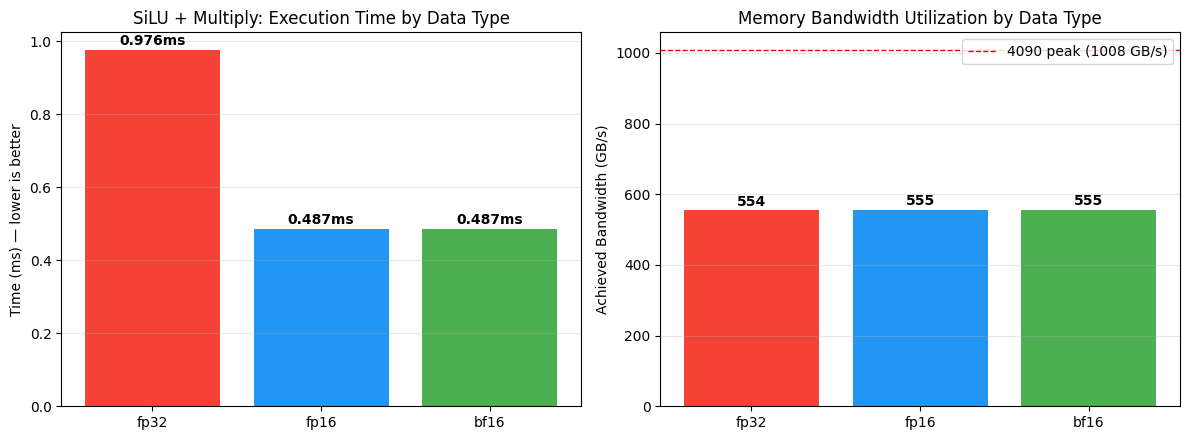

All three types achieve similar bandwidth utilization (~55% of peak).
But fp16/bf16 move half as many bytes, so they finish in half the time.
The GPU memory bus is the bottleneck — smaller data types = faster.


In [10]:
# Visualize the dtype difference
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

names = [r[0] for r in dtype_results]
times = [r[2] for r in dtype_results]
bandwidths = [r[3] for r in dtype_results]

# Left: execution time
ax = axes[0]
colors = ['#f44336', '#2196F3', '#4CAF50']
bars = ax.bar(names, times, color=colors)
ax.set_ylabel('Time (ms) — lower is better')
ax.set_title('SiLU + Multiply: Execution Time by Data Type')
ax.grid(True, alpha=0.3, axis='y')
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{t:.3f}ms', ha='center', va='bottom', fontweight='bold')

# Right: bandwidth utilization
ax = axes[1]
bars = ax.bar(names, bandwidths, color=colors)
ax.axhline(y=THEORETICAL_BW, color='red', linestyle='--', linewidth=1, label=f'4090 peak ({THEORETICAL_BW} GB/s)')
ax.set_ylabel('Achieved Bandwidth (GB/s)')
ax.set_title('Memory Bandwidth Utilization by Data Type')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar, bw in zip(bars, bandwidths):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{bw:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("All three types achieve similar bandwidth utilization (~55% of peak).")
print("But fp16/bf16 move half as many bytes, so they finish in half the time.")
print("The GPU memory bus is the bottleneck — smaller data types = faster.")

### Precision vs. Speed: Does the accuracy loss matter?

Let's see how much numerical error each data type introduces compared to fp32.

In [11]:
# Generate test data in fp32 (ground truth)
torch.manual_seed(42)
x_fp32 = torch.randn((1024, 4096), dtype=torch.float32, device="cuda")
w_fp32 = torch.randn(4096, dtype=torch.float32, device="cuda")

# Compute RMSNorm in fp32 ("perfect" answer)
variance = x_fp32.pow(2).mean(dim=-1, keepdim=True)
ref = x_fp32 * torch.rsqrt(variance + 1e-6) * w_fp32

print(f"{'Type':<8} {'Max error':>12} {'Mean error':>12} {'Relative':>12}")
print("-" * 48)

for name, dtype in [("fp32", torch.float32), ("fp16", torch.float16), ("bf16", torch.bfloat16)]:
    x = x_fp32.to(dtype)
    w = w_fp32.to(dtype)

    variance = x.float().pow(2).mean(dim=-1, keepdim=True)
    result = (x.float() * torch.rsqrt(variance + 1e-6) * w.float()).to(dtype).float()

    abs_err = (result - ref).abs()
    rel_err = abs_err / (ref.abs() + 1e-8)

    print(f"{name:<8} {abs_err.max().item():>12.6f} {abs_err.mean().item():>12.8f} {rel_err.mean().item():>12.8f}")

print()
print("fp16 and bf16 introduce small errors (~0.001) that are invisible")
print("in model outputs. Modern models are trained to be robust to this.")
print("bf16 has slightly more error (fewer mantissa bits) but never overflows.")

Type        Max error   Mean error     Relative
------------------------------------------------
fp32         0.000000   0.00000000   0.00000000
fp16         0.007914   0.00018613   0.00029135
bf16         0.083960   0.00148810   0.00231437

fp16 and bf16 introduce small errors (~0.001) that are invisible
in model outputs. Modern models are trained to be robust to this.
bf16 has slightly more error (fewer mantissa bits) but never overflows.


---
## Part 6: Memory Footprint — Fusion Saves RAM, Not Just Time

Kernel fusion doesn't just make things faster — it reduces **peak GPU memory usage**. This matters because GPU memory is the most constrained resource in AI inference. If your model barely fits in 24 GB of VRAM, eliminating intermediate tensors could be the difference between running and crashing with an OOM error.

Let's measure exactly how much memory each approach uses.

In [12]:
def measure_peak_memory(func):
    """Run a function and return peak GPU memory allocated in MB."""
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    baseline = torch.cuda.memory_allocated()
    func()
    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated()
    return (peak - baseline) / 1e6  # MB above baseline


n_tokens = 8192
inter = 11008

# Pre-allocate inputs outside the measurement
gate = torch.randn((n_tokens, inter), dtype=torch.float16, device="cuda")
up = torch.randn((n_tokens, inter), dtype=torch.float16, device="cuda")
gate_up_cat = torch.cat([gate, up], dim=-1).contiguous()

print(f"Peak memory for SiLU + Multiply ({n_tokens} x {inter}, float16)")
print(f"Input data: {gate.numel() * 2 * 2 / 1e6:.0f} MB (gate + up)")
print()

# Unfused: PyTorch creates an intermediate tensor for silu(gate)
mem_unfused = measure_peak_memory(
    lambda: torch.nn.functional.silu(gate) * up
)

# Fused: Hub kernel writes directly to output, no intermediate
out_hub = torch.empty((n_tokens, inter), dtype=torch.float16, device="cuda")
mem_fused = measure_peak_memory(
    lambda: act_kernel.silu_and_mul(out_hub, gate_up_cat)
)

# Our Triton kernel
mem_triton = measure_peak_memory(
    lambda: triton_silu_mul(gate, up)
)

intermediate_size_mb = n_tokens * inter * 2 / 1e6  # the silu(gate) intermediate

print(f"  {'Approach':<20} {'Peak memory':>14} {'Overhead':>14}")
print(f"  {'='*50}")
print(f"  {'PyTorch (unfused)':<20} {mem_unfused:>10.0f} MB   {mem_unfused - mem_fused:>+10.0f} MB")
print(f"  {'Our Triton kernel':<20} {mem_triton:>10.0f} MB   {mem_triton - mem_fused:>+10.0f} MB")
print(f"  {'Hub kernel (fused)':<20} {mem_fused:>10.0f} MB   {'(baseline)':>14}")
print()
print(f"  The unfused version allocates ~{intermediate_size_mb:.0f} MB for the intermediate")
print(f"  silu(gate) tensor. Fused kernels skip this entirely.")
print()
print(f"  In a 32-layer model, that's {intermediate_size_mb * 32 / 1e3:.1f} GB of peak memory savings —")
print(f"  potentially enough to fit a larger model or batch in your 24 GB of VRAM.")

Peak memory for SiLU + Multiply (8192 x 11008, float16)
Input data: 361 MB (gate + up)

  Approach                Peak memory       Overhead
  PyTorch (unfused)           361 MB         +361 MB
  Our Triton kernel           180 MB         +180 MB
  Hub kernel (fused)            0 MB       (baseline)

  The unfused version allocates ~180 MB for the intermediate
  silu(gate) tensor. Fused kernels skip this entirely.

  In a 32-layer model, that's 5.8 GB of peak memory savings —
  potentially enough to fit a larger model or batch in your 24 GB of VRAM.


### Full model memory comparison

In [13]:
# Compare memory usage across all data types for a full MLP forward pass
n_tokens = 4096
hidden_size = 4096
intermediate_size = 11008

print(f"MLP block peak memory by data type ({n_tokens} tokens)")
print(f"{'Type':<8} {'Peak alloc':>12} {'Model size':>12} {'Activation':>12}")
print("-" * 48)

mem_results = []

for name, dtype in [("fp32", torch.float32), ("fp16", torch.float16), ("bf16", torch.bfloat16)]:
    mdl = LLaMAStyleMLP(hidden_size, intermediate_size).to(device="cuda", dtype=dtype)
    x = torch.randn((n_tokens, hidden_size), dtype=dtype, device="cuda")

    model_bytes = sum(p.numel() * p.element_size() for p in mdl.parameters())

    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    before = torch.cuda.memory_allocated()
    with torch.no_grad():
        out = mdl(x)
    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() - before

    activation_mem = peak - model_bytes
    mem_results.append((name, peak / 1e6, model_bytes / 1e6, max(0, activation_mem) / 1e6))
    print(f"{name:<8} {peak/1e6:>9.0f} MB  {model_bytes/1e6:>9.0f} MB  {max(0,activation_mem)/1e6:>9.0f} MB")

    del mdl, x, out
    torch.cuda.empty_cache()

print()
print(f"fp32→fp16 cuts memory roughly in half. This is why fp16/bf16 inference")
print(f"is standard — it's not just faster, it lets you fit larger models.")

MLP block peak memory by data type (4096 tokens)
Type       Peak alloc   Model size   Activation
------------------------------------------------
fp32           789 MB        541 MB        247 MB
fp16           394 MB        271 MB        124 MB
bf16           394 MB        271 MB        124 MB

fp32→fp16 cuts memory roughly in half. This is why fp16/bf16 inference
is standard — it's not just faster, it lets you fit larger models.


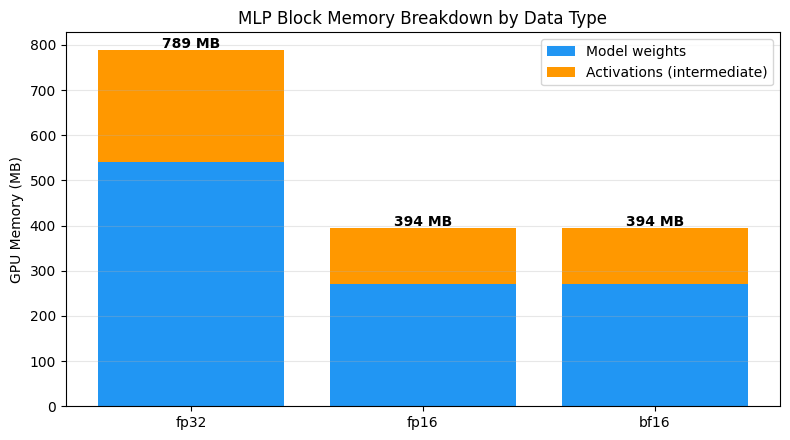

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))

names = [r[0] for r in mem_results]
model_mem = [r[2] for r in mem_results]
act_mem = [r[3] for r in mem_results]

x_pos = range(len(names))
bars1 = ax.bar(x_pos, model_mem, label='Model weights', color='#2196F3')
bars2 = ax.bar(x_pos, act_mem, bottom=model_mem, label='Activations (intermediate)', color='#FF9800')

ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_ylabel('GPU Memory (MB)')
ax.set_title('MLP Block Memory Breakdown by Data Type')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i, (m, a) in enumerate(zip(model_mem, act_mem)):
    ax.text(i, m + a + 5, f'{m+a:.0f} MB', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Part 7: When to Use What — A Decision Framework

After three notebooks of benchmarks, here's the practical summary:

In [15]:
# Final comprehensive comparison
n_tokens = 4096
gate = torch.randn((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
up = torch.randn((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
gate_up_cat = torch.cat([gate, up], dim=-1).contiguous()
out_hub = torch.empty_like(gate)

@torch.compile
def compiled_fn(g, u):
    return torch.nn.functional.silu(g) * u

# Warm up compile
for _ in range(5): compiled_fn(gate, up)
torch.cuda.synchronize()

approaches = [
    ("PyTorch eager",    lambda: torch.nn.functional.silu(gate) * up,     "Zero",            "None"),
    ("torch.compile",    lambda: compiled_fn(gate, up),                    "1 decorator",     "Slow first call"),
    ("Hub kernel",       lambda: act_kernel.silu_and_mul(out_hub, gate_up_cat), "1 line",     "Hub must have it"),
    ("Custom Triton",    lambda: triton_silu_mul(gate, up),                "~15 lines",       "Full control"),
]

print(f"Final comparison: SiLU + Multiply, {n_tokens} x {intermediate_size}, float16")
print()
print(f"{'Approach':<20} {'Time (ms)':>10} {'Speedup':>8} {'Effort':<16} {'Tradeoff'}")
print("=" * 80)

base_ms = None
for name, func, effort, tradeoff in approaches:
    ms = benchmark(func)
    if base_ms is None:
        base_ms = ms
    print(f"{name:<20} {ms:>8.4f}   {base_ms/ms:>6.2f}x   {effort:<16} {tradeoff}")

Final comparison: SiLU + Multiply, 4096 x 11008, float16

Approach              Time (ms)  Speedup Effort           Tradeoff
PyTorch eager          0.4870     1.00x   Zero             None
torch.compile          0.2915     1.67x   1 decorator      Slow first call
Hub kernel             0.2938     1.66x   1 line           Hub must have it
Custom Triton          0.2915     1.67x   ~15 lines        Full control


## Summary

### What we covered in this notebook

**Writing GPU kernels with Triton:** You wrote two kernels from scratch — a simple element-wise fused activation, and a more complex RMSNorm with a reduction. Triton gives you Python-like syntax that compiles to GPU machine code.

**`torch.compile`:** PyTorch's built-in compiler auto-fuses operations with zero manual effort. It matches custom kernel performance for standard operations. The cost is a slow first call (compilation) and less control over what gets fused.

**The four-way race showed convergence:** Custom Triton, Hub kernels, and `torch.compile` all hit the same memory bandwidth ceiling. Once you fuse operations, there's no magic left — you're limited by how fast the 4090 can move bytes.

**Data types matter as much as kernel optimization:** Switching from fp32 to fp16/bf16 gives a reliable 2x speedup *and* halves memory usage. This is often the single biggest optimization you can make.

**Fusion saves memory, not just time:** Eliminating intermediate tensors reduces peak VRAM. Across a 32-layer model, this can free gigabytes — potentially the difference between a model fitting on your GPU or not.

### When to use what

| Situation | Recommendation |
|-----------|---------------|
| Quick prototype, standard ops | `torch.compile` |
| Production inference server | Hub kernels (battle-tested, no compile overhead) |
| Custom operation not in PyTorch | Write a Triton kernel |
| Maximum performance, willing to invest time | Custom CUDA C++ |
| Not sure yet | Start with `torch.compile`, profile, replace bottlenecks |

In [16]:
!nvidia-smi

Tue Feb 17 11:07:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
| 30%   37C    P2            154W /  450W |    2646MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----